<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html ising.do.txt  -->

## The Ising model

The one-dimensional Ising model with nearest neighbor interaction, no
external field and a constant coupling constant $J$ is given by

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto1} \tag{1}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins
in the system is determined by $L$. For the one-dimensional system
there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of
$J = 1$. To get enough training data we will generate 10000 states
with their respective energies.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

Here we use ordinary least squares
regression to predict the energy for the nearest neighbor
one-dimensional Ising model on a ring, i.e., the endpoints wrap
around. We will use linear regression to fit a value for
the coupling constant to achieve this.

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto2} \tag{2}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a state dependent
coupling constant. This latter expression can be formulated as
a matrix-product

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    \boldsymbol{H} = \boldsymbol{X} J,
\label{_auto3} \tag{3}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is a matrix which consists of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, that is

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon},
\label{_auto4} \tag{4}
\end{equation}
$$

We split the data in training and test data as discussed in the previous example

In [2]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In the ordinary least squares method we choose the cost function

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta})= \frac{1}{n}\left\{(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})\right\}.
\label{_auto5} \tag{5}
\end{equation}
$$

We then find the extremal point of $C$ by taking the derivative with respect to $\boldsymbol{\beta}$ as discussed above.
This yields the expression for $\boldsymbol{\beta}$ to be

$$
\boldsymbol{\beta} = \frac{\boldsymbol{X}^T \boldsymbol{y}}{\boldsymbol{X}^T \boldsymbol{X}},
$$

which immediately imposes some requirements on $\boldsymbol{X}$ as there must exist
an inverse of $\boldsymbol{X}^T \boldsymbol{X}$. If the expression we are modeling contains an
intercept, i.e., a constant term, we must make sure that the
first column of $\boldsymbol{X}$ consists of $1$. We do this here

In [3]:
X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)
X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

Doing the inversion directly turns out to be a bad idea since the matrix
$\boldsymbol{X}^T\boldsymbol{X}$ is singular. An alternative approach is to use the **singular
value decomposition**. Using the definition of the Moore-Penrose
pseudoinverse we can write the equation for $\boldsymbol{\beta}$ as

$$
\boldsymbol{\beta} = \boldsymbol{X}^{+}\boldsymbol{y},
$$

where the pseudoinverse of $\boldsymbol{X}$ is given by

$$
\boldsymbol{X}^{+} = \frac{\boldsymbol{X}^T}{\boldsymbol{X}^T\boldsymbol{X}}.
$$

Using singular value decomposition we can decompose the matrix  $\boldsymbol{X} = \boldsymbol{U}\boldsymbol{\Sigma} \boldsymbol{V}^T$,
where $\boldsymbol{U}$ and $\boldsymbol{V}$ are orthogonal(unitary) matrices and $\boldsymbol{\Sigma}$ contains the singular values (more details below).
where $X^{+} = V\Sigma^{+} U^T$. This reduces the equation for
$\omega$ to

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    \boldsymbol{\beta} = \boldsymbol{V}\boldsymbol{\Sigma}^{+} \boldsymbol{U}^T \boldsymbol{y}.
\label{_auto6} \tag{6}
\end{equation}
$$

Note that solving this equation by actually doing the pseudoinverse
(which is what we will do) is not a good idea as this operation scales
as $\mathcal{O}(n^3)$, where $n$ is the number of elements in a
general matrix. Instead, doing $QR$-factorization and solving the
linear system as an equation would reduce this down to
$\mathcal{O}(n^2)$ operations.

In [4]:
def ols_svd(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

In [5]:
beta = ols_svd(X_train_own,y_train)

When extracting the $J$-matrix  we need to make sure that we remove the intercept, as is done here

In [6]:
J = beta[1:].reshape(L, L)

A way of looking at the coefficients in $J$ is to plot the matrices as images.

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/4162706317.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im)
/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/4162706317.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


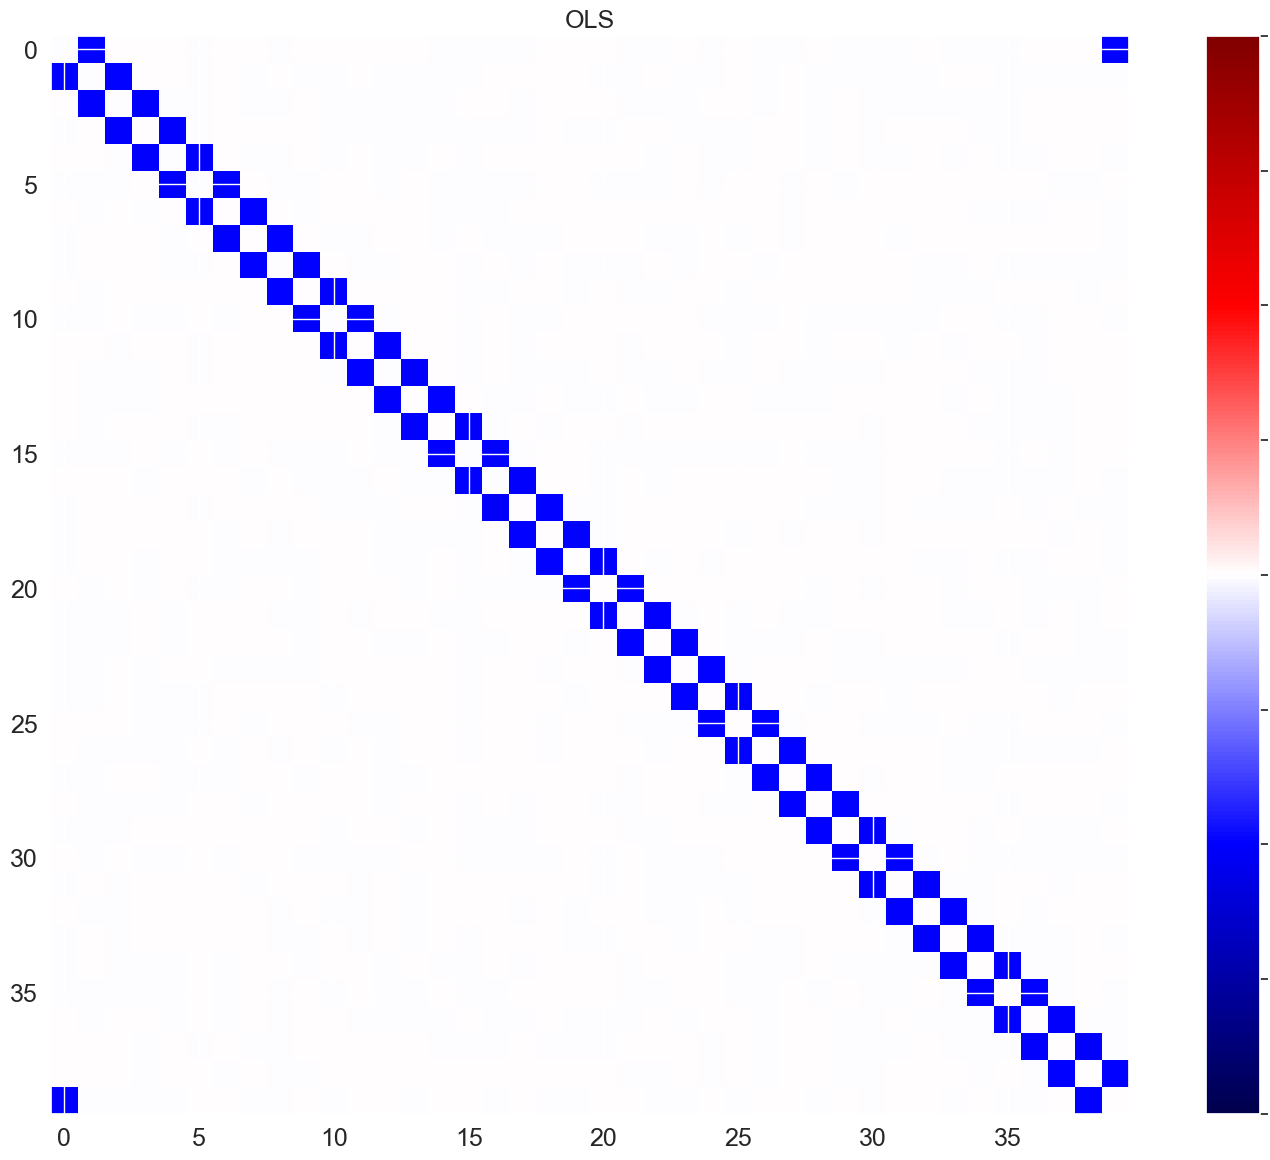

In [7]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J, **cmap_args)
plt.title("OLS", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

It is interesting to note that OLS
considers both $J_{j, j + 1} = -0.5$ and $J_{j, j - 1} = -0.5$ as
valid matrix elements for $J$.
In our discussion below on hyperparameters and Ridge and Lasso regression we will see that
this problem can be removed, partly and only with Lasso regression. 

In this case our matrix inversion was actually possible. The obvious question now is what is the mathematics behind the SVD?

Let us now 
focus on Ridge and Lasso regression as well. We repeat some of the
basic parts of the Ising model and the setup of the training and test
data.  The one-dimensional Ising model with nearest neighbor
interaction, no external field and a constant coupling constant $J$ is
given by

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    H = -J \sum_{k}^L s_k s_{k + 1},
\label{_auto7} \tag{7}
\end{equation}
$$

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins in the system is determined by $L$. For the one-dimensional system there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of $J = 1$. To get enough training data we will generate 10000 states with their respective energies.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
import tqdm
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

A more general form for the one-dimensional Ising model is

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\label{_auto8} \tag{8}
\end{equation}
$$

Here we allow for interactions beyond the nearest neighbors and a more
adaptive coupling matrix. This latter expression can be formulated as
a matrix-product on the form

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
    H = X J,
\label{_auto9} \tag{9}
\end{equation}
$$

where $X_{jk} = s_j s_k$ and $J$ is the matrix consisting of the
elements $-J_{jk}$. This form of writing the energy fits perfectly
with the form utilized in linear regression, viz.

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
    \boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}.
\label{_auto10} \tag{10}
\end{equation}
$$

We organize the data as we did above

In [9]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

We will do all fitting with **Scikit-Learn**,

In [10]:
clf = skl.LinearRegression().fit(X_train, y_train)

When  extracting the $J$-matrix we make sure to remove the intercept

In [11]:
J_sk = clf.coef_.reshape(L, L)

And then we plot the results

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/3777801602.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im)
/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/3777801602.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


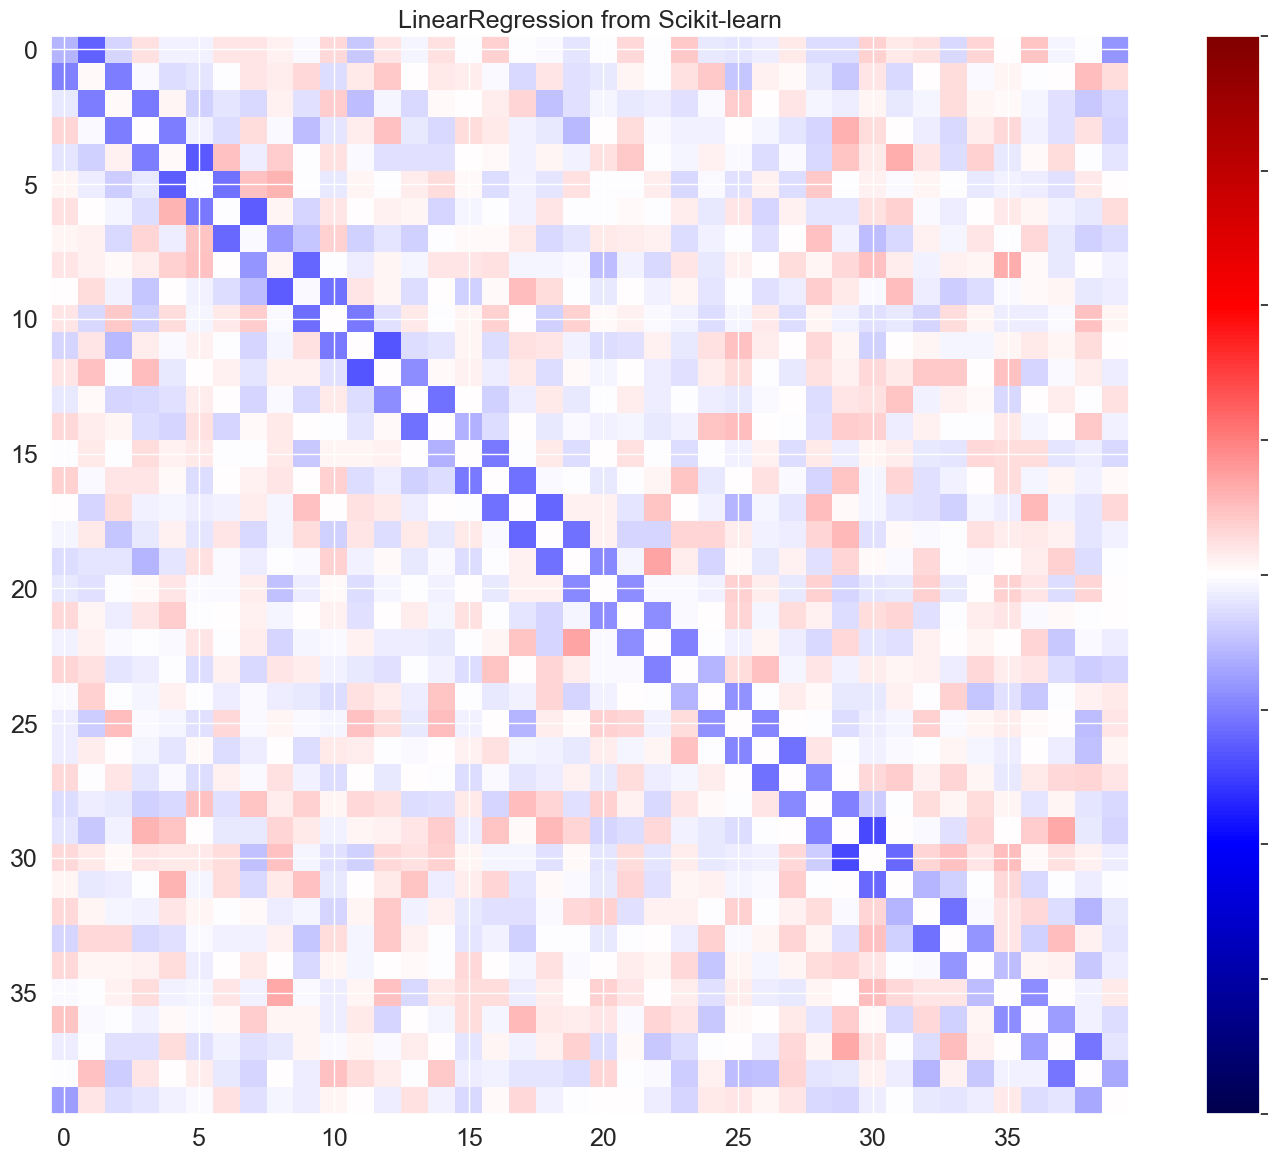

In [12]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

The results agree perfectly with our previous discussion where we used our own code.

Having explored the ordinary least squares we move on to ridge
regression. In ridge regression we include a **regularizer**. This
involves a new cost function which leads to a new estimate for the
weights $\boldsymbol{\beta}$. This results in a penalized regression problem. The
cost function is given by

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta}; \lambda) = (\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y}) + \lambda \boldsymbol{\beta}^T\boldsymbol{\beta}.
\label{_auto11} \tag{11}
\end{equation}
$$

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/438060758.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im)
/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/438060758.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


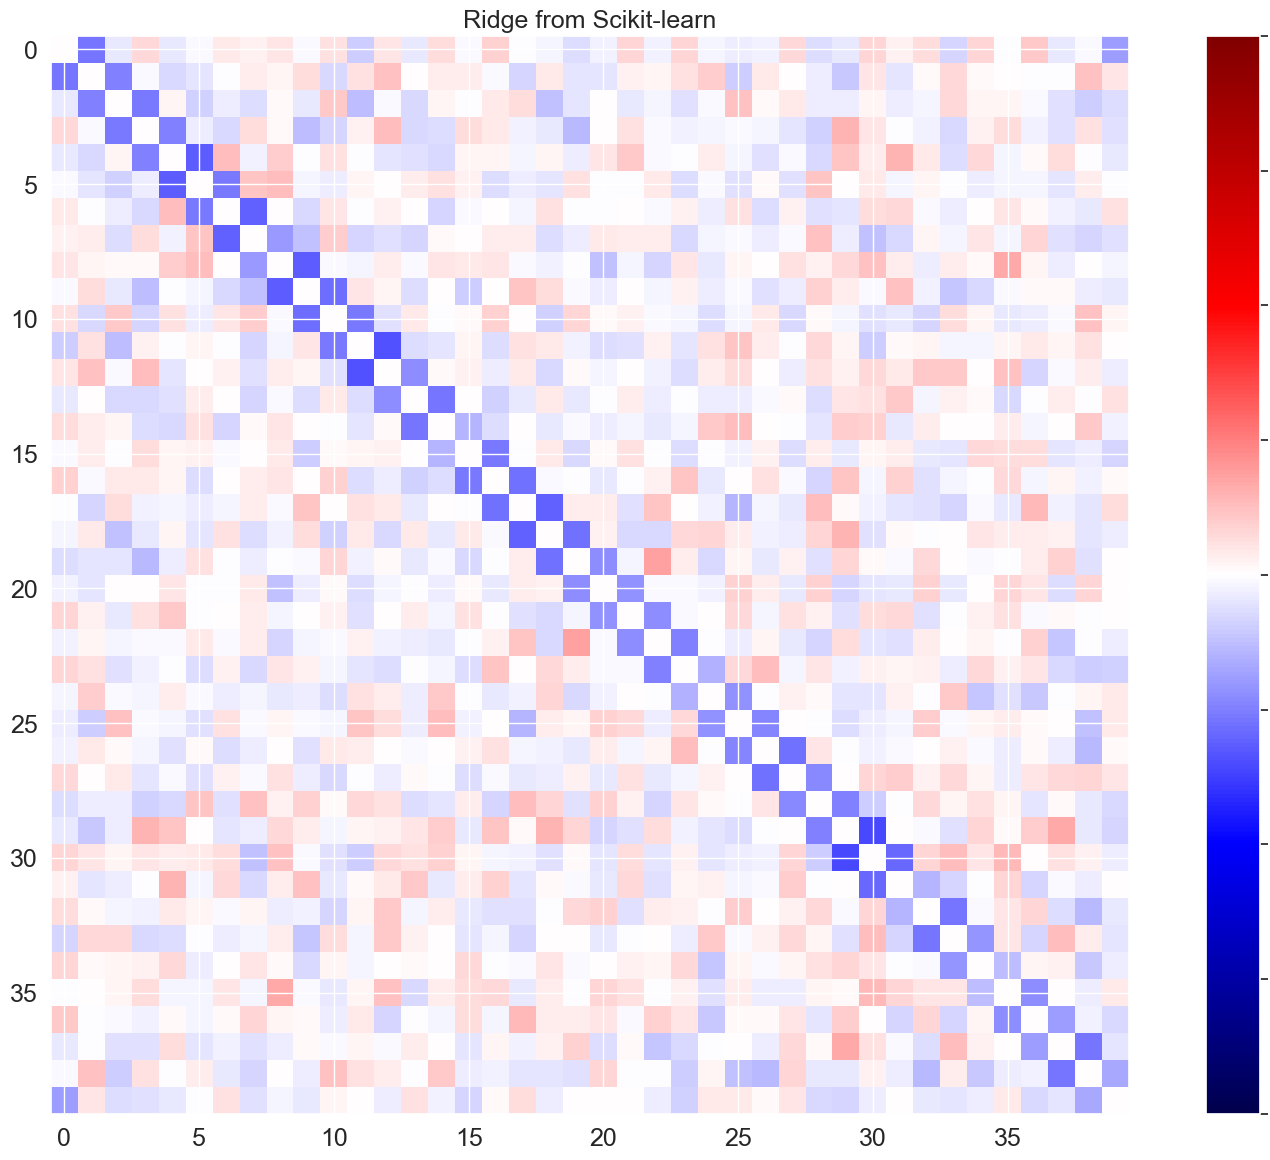

In [13]:
_lambda = 0.1
clf_ridge = skl.Ridge(alpha=_lambda).fit(X_train, y_train)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

In the **Least Absolute Shrinkage and Selection Operator** (LASSO)-method we get a third cost function.

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
    C(\boldsymbol{X}, \boldsymbol{\beta}; \lambda) = (\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{y}) + \lambda \sqrt{\boldsymbol{\beta}^T\boldsymbol{\beta}}.
\label{_auto12} \tag{12}
\end{equation}
$$

Finding the extremal point of this cost function is not so straight-forward as in least squares and ridge. We will therefore rely solely on the function ``Lasso`` from **Scikit-Learn**.

/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/3544313922.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(im)
/var/folders/td/3yk470mj5p931p9dtkk0y6jw0000gn/T/ipykernel_68696/3544313922.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


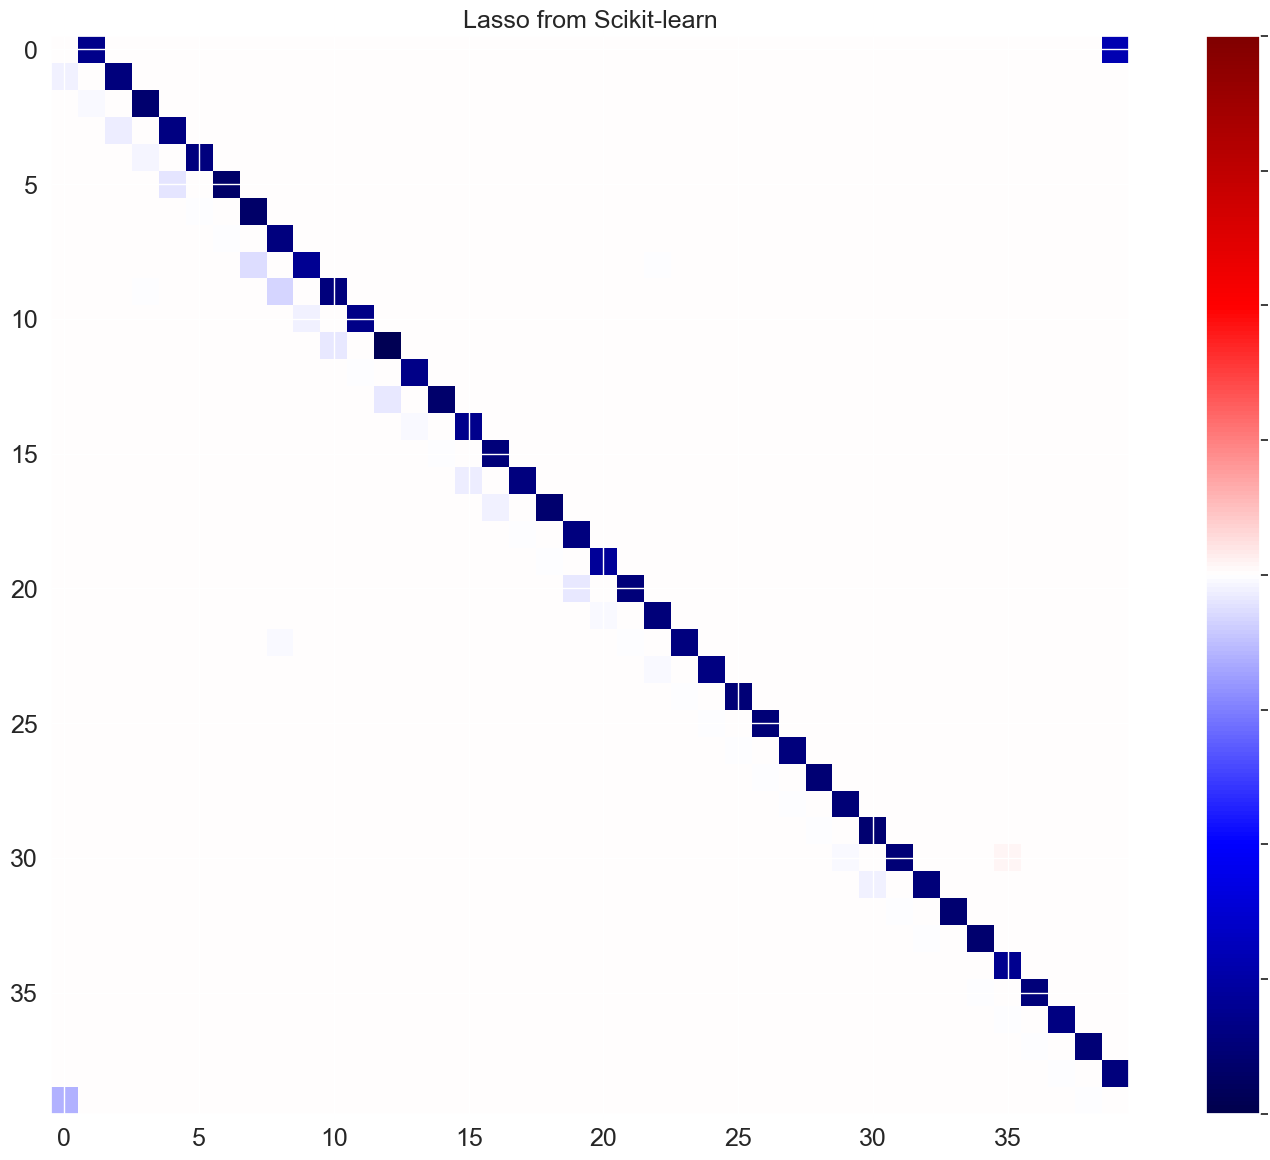

In [14]:
clf_lasso = skl.Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

It is quite striking how LASSO breaks the symmetry of the coupling
constant as opposed to ridge and OLS. We get a sparse solution with
$J_{j, j + 1} = -1$.

We see how the different models perform for a different set of values for $\lambda$.

  0%|                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+00, tolerance: 1.467e+00
  model = cd_fast.enet_coordinate_descent(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


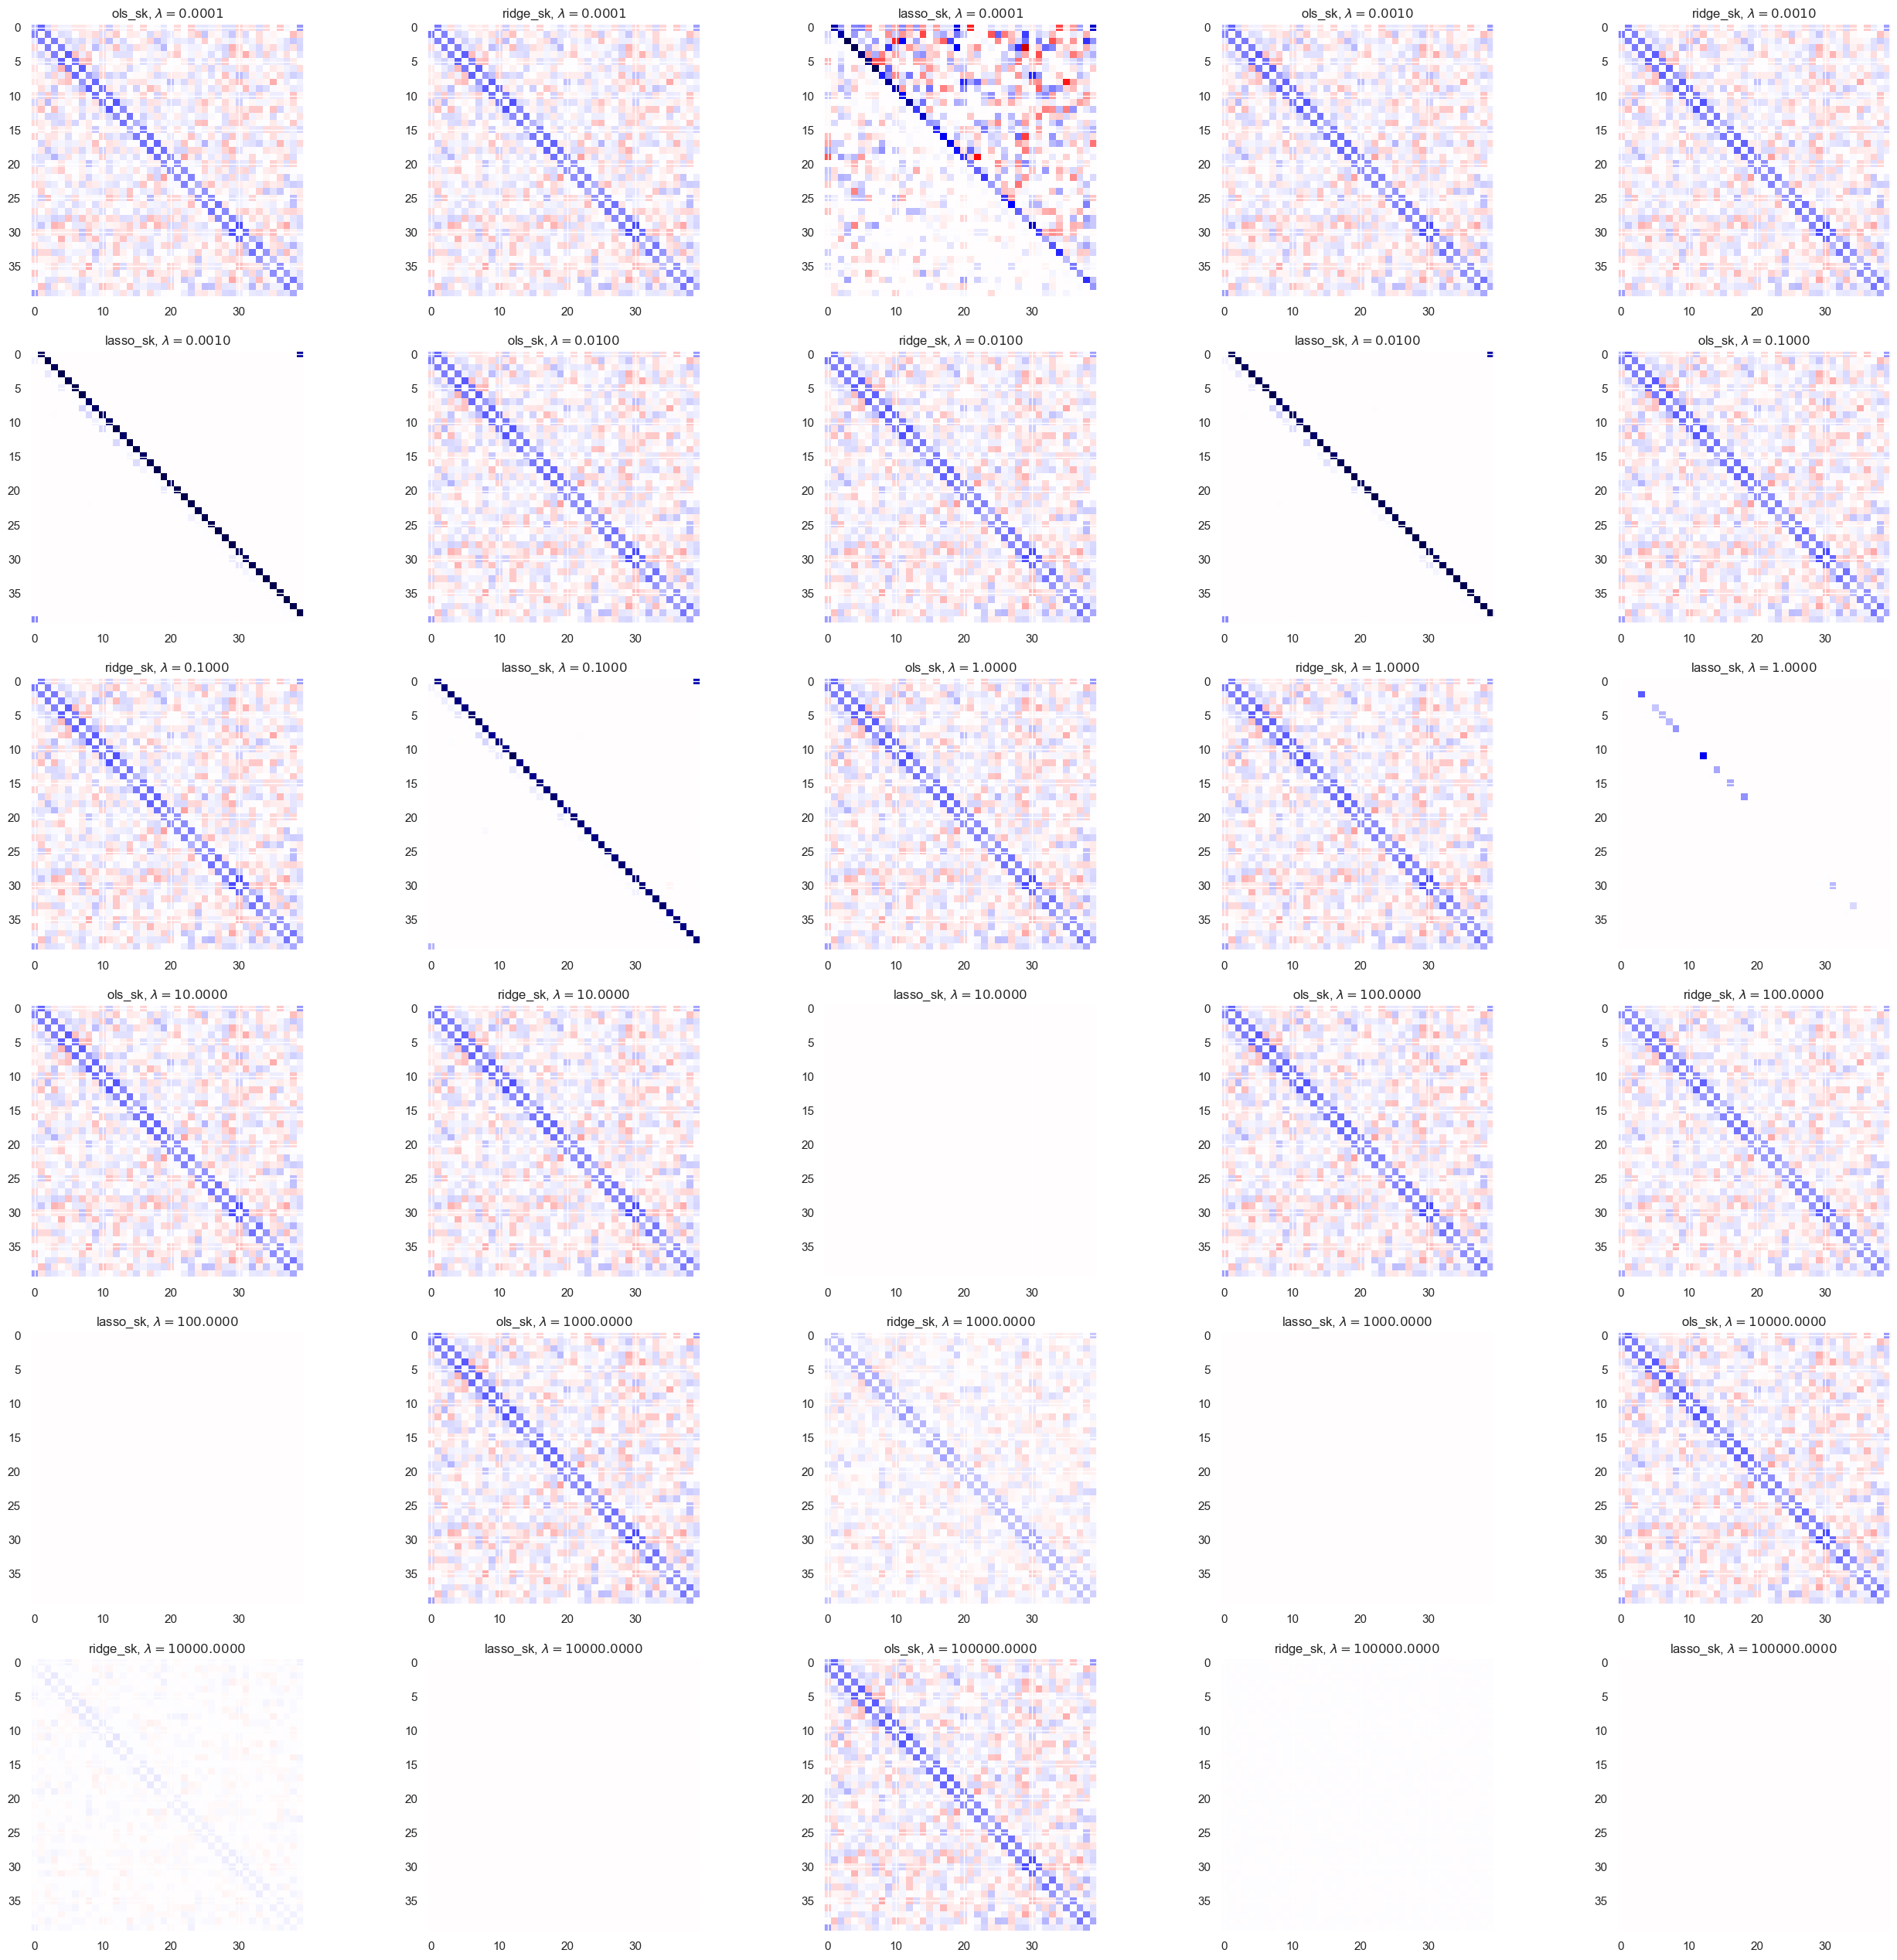

In [15]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

We see that LASSO reaches a good solution for low
values of $\lambda$, but will "wither" when we increase $\lambda$ too
much. Ridge is more stable over a larger range of values for
$\lambda$, but eventually also fades away.

To determine which value of $\lambda$ is best we plot the accuracy of
the models when predicting the training and the testing set. We expect
the accuracy of the training set to be quite good, but if the accuracy
of the testing set is much lower this tells us that we might be
subject to an overfit model. The ideal scenario is an accuracy on the
testing set that is close to the accuracy of the training set.

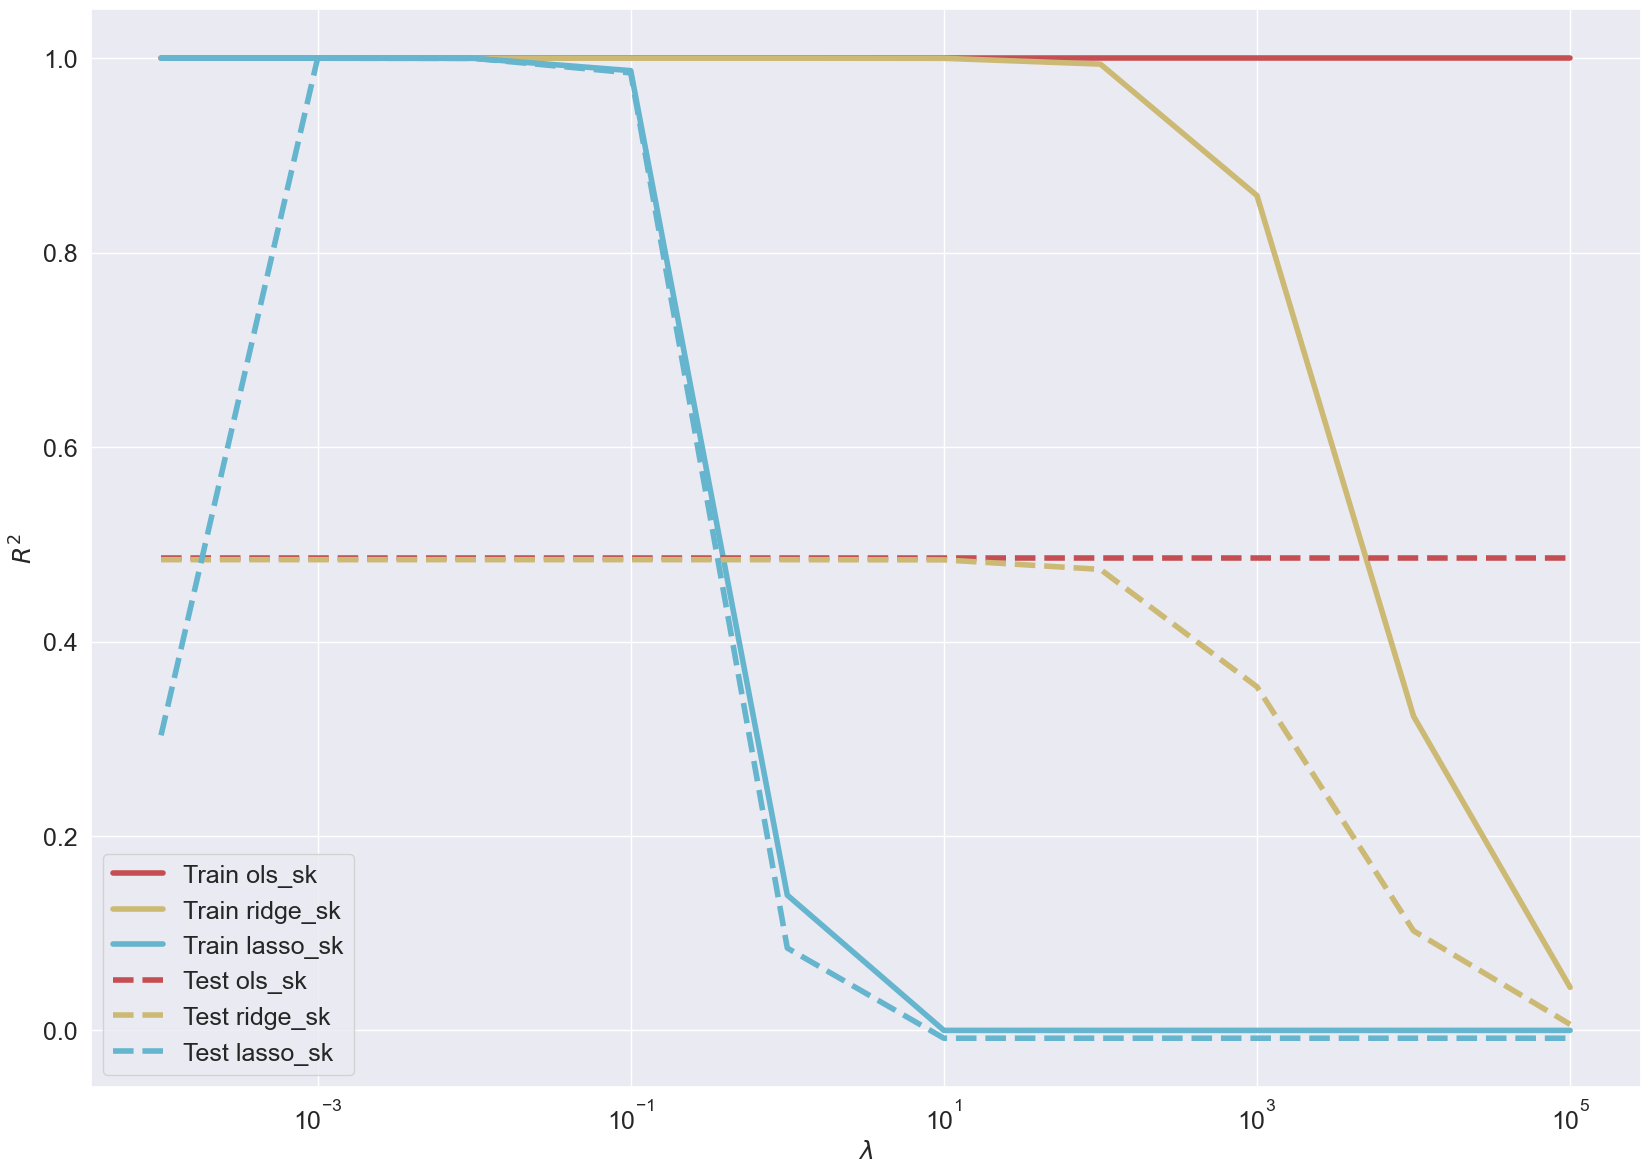

In [16]:
fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

From the above figure we can see that LASSO with $\lambda = 10^{-2}$
achieves a very good accuracy on the test set. This by far surpasses the
other models for all values of $\lambda$.

## Exercises and Projects

The main aim of this project is to study in more detail various
regression methods, including the Ordinary Least Squares (OLS) method,
The total score is **100** points. Each subtask has its own final score.

We will first study how to fit polynomials to a specific
two-dimensional function called [Franke's
function](http://www.dtic.mil/dtic/tr/fulltext/u2/a081688.pdf).  This
is a function which has been widely used when testing various
interpolation and fitting algorithms. Furthermore, after having
established the model and the method, we will employ resamling
techniques such as cross-validation and/or bootstrap in order to perform a
proper assessment of our models. We will also study in detail the
so-called Bias-Variance trade off.

The Franke function, which is a weighted sum of four exponentials  reads as follows

$$
\begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}
$$

The function will be defined for $x,y\in [0,1]$.  Our first step will
be to perform an OLS regression analysis of this function, trying out
a polynomial fit with an $x$ and $y$ dependence of the form $[x, y,
x^2, y^2, xy, \dots]$. We will also include bootstrap first as
a resampling technique.  After that we will include the cross-validation technique. As in homeworks 1 and 2, we can use a uniform
distribution to set up the arrays of values for $x$ and $y$, or as in
the example below just a set of fixed 
values for $x$ and $y$ with a given step
size.  We will fit a
function (for example a polynomial) of $x$ and $y$.  Thereafter we
will repeat much of the same procedure using the Ridge and Lasso
regression methods, introducing thus a dependence on the bias
(penalty) $\lambda$.

Finally we are going to use (real) digital terrain data and try to
reproduce these data using the same methods. We will also try to go
beyond the second-order polynomials metioned above and explore 
which polynomial fits the data best.

The Python code for the Franke function is included here (it performs also a three-dimensional plot of it)

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Exercise: Ordinary Least Square (OLS) on the Franke function

We will generate our own dataset for a function
$\mathrm{FrankeFunction}(x,y)$ with $x,y \in [0,1]$. The function
$f(x,y)$ is the Franke function. You should explore also the addition
of an added stochastic noise to this function using the normal
distribution $N(0,1)$.

*Write your own code* (using either a matrix inversion or a singular
value decomposition from e.g., **numpy** ) or use your code from
homeworks 1 and 2 and perform a standard least square regression
analysis using polynomials in $x$ and $y$ up to fifth order. Find the
[confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) of the parameters (estimators) $\beta$ by computing their
variances, evaluate the Mean Squared error (MSE)

$$
MSE(\hat{y},\hat{\tilde{y}}) = \frac{1}{n}
\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2,
$$

and the $R^2$ score function.  If $\tilde{\hat{y}}_i$ is the predicted
value of the $i-th$ sample and $y_i$ is the corresponding true value,
then the score $R^2$ is defined as

$$
R^2(\hat{y}, \tilde{\hat{y}}) = 1 - \frac{\sum_{i=0}^{n - 1} (y_i - \tilde{y}_i)^2}{\sum_{i=0}^{n - 1} (y_i - \bar{y})^2},
$$

where we have defined the mean value  of $\hat{y}$ as

$$
\bar{y} =  \frac{1}{n} \sum_{i=0}^{n - 1} y_i.
$$

Your code has to include a scaling of the data (for example by
subtracting the mean value), and
a split of the data in training and test data. For this exercise you can
either write your own code or use for example the function for
splitting training data provided by the library **Scikit-Learn** (make
sure you have installed it).  This function is called
$train\_test\_split$.  **You should present a critical discussion of why and how you have scaled or not scaled the data**.

It is normal in essentially all Machine Learning studies to split the
data in a training set and a test set (eventually  also an additional
validation set).  There
is no explicit recipe for how much data should be included as training
data and say test data.  An accepted rule of thumb is to use
approximately $2/3$ to $4/5$ of the data as training data.

You can easily reuse the solutions to your exercises from week 35 and week 36.

### Exercise: Bias-variance trade-off and resampling techniques

Our aim here is to study the bias-variance trade-off by implementing the **bootstrap** resampling technique.

With a code which does OLS and includes resampling techniques, 
we will now discuss the bias-variance trade-off in the context of
continuous predictions such as regression. However, many of the
intuitions and ideas discussed here also carry over to classification
tasks and basically all Machine Learning algorithms. 

Before you perform an analysis of the bias-variance trade-off on your test data, make
first a figure similar to Fig. 2.11 of Hastie, Tibshirani, and
Friedman. Figure 2.11 of this reference displays only the test and training MSEs. The test MSE can be used to 
indicate possible regions of low/high bias and variance. You will most likely not get an
equally smooth curve!

With this result we move on to the bias-variance trade-off analysis.

Consider a
dataset $\mathcal{L}$ consisting of the data
$\mathbf{X}_\mathcal{L}=\{(y_j, \boldsymbol{x}_j), j=0\ldots n-1\}$.

Let us assume that the true data is generated from a noisy model

$$
\boldsymbol{y}=f(\boldsymbol{x}) + \boldsymbol{\epsilon}.
$$

Here $\epsilon$ is normally distributed with mean zero and standard
deviation $\sigma^2$.

In our derivation of the ordinary least squares method we defined then
an approximation to the function $f$ in terms of the parameters
$\boldsymbol{\beta}$ and the design matrix $\boldsymbol{X}$ which embody our model,
that is $\boldsymbol{\tilde{y}}=\boldsymbol{X}\boldsymbol{\beta}$.

The parameters $\boldsymbol{\beta}$ are in turn found by optimizing the means
squared error via the so-called cost function

$$
C(\boldsymbol{X},\boldsymbol{\beta}) =\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2=\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right].
$$

Here the expected value $\mathbb{E}$ is the sample value. 

Show that you can rewrite  this as

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\frac{1}{n}\sum_i(f_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2+\frac{1}{n}\sum_i(\tilde{y}_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2+\sigma^2.
$$

Explain what the terms mean, which one is the bias and which one is
the variance and discuss their interpretations.

Perform then a bias-variance analysis of the Franke function by
studying the MSE value as function of the complexity of your model.

Discuss the bias and variance trade-off as function
of your model complexity (the degree of the polynomial) and the number
of data points, and possibly also your training and test data using the **bootstrap** resampling method.

Note also that when you calculate the bias, in all applications you don't know the function values $f_i$. You would hence replace them with the actual data points $y_i$.

### Exercise:  Cross-validation as resampling techniques, adding more complexity

The aim here is to write your own code for another widely popular
resampling technique, the so-called cross-validation method.  Again,
before you start with cross-validation approach, you should scale your
data.

Implement the $k$-fold cross-validation algorithm (write your own
code) and evaluate again the MSE function resulting
from the test folds. You can compare your own code with that from
**Scikit-Learn** if needed. 

Compare the MSE you get from your cross-validation code with the one
you got from your **bootstrap** code. Comment your results. Try $5-10$
folds.  You can also compare your own cross-validation code with the
one provided by **Scikit-Learn**.

### Exercise: Ridge Regression on the Franke function  with resampling

Write your own code for the Ridge method, either using matrix
inversion or the singular value decomposition as done in the previous
exercise. Perform the same bootstrap analysis as in the
Exercise 2  (for the same polynomials) and the cross-validation  in exercise 3 but now for different values of $\lambda$. Compare and
analyze your results with those obtained in exercises 1-3. Study the
dependence on $\lambda$.

Study also the bias-variance trade-off as function of various values of
the parameter $\lambda$. For the bias-variance trade-off, use the **bootstrap** resampling method. Comment your results.

### Exercise: Lasso Regression on the Franke function  with resampling

This exercise is essentially a repeat of the previous two ones, but now
with Lasso regression. Write either your own code (difficult and optional) or, in this case,
you can also use the functionalities of **Scikit-Learn** (recommended). 
Give a
critical discussion of the three methods and a judgement of which
model fits the data best.  Perform here as well an analysis of the bias-variance trade-off using the **bootstrap** resampling technique and an analysis of the mean squared error using cross-validation.

### Exercise: Analysis of real data

With our codes functioning and having been tested properly on a
simpler function we are now ready to look at real data. We will
essentially repeat in this exercise what was done in exercises 1-5. However, we
need first to download the data and prepare properly the inputs to our
codes.  We are going to download digital terrain data from the website
<https://earthexplorer.usgs.gov/>,

Or, if you prefer, we have placed selected datafiles at <https://github.com/CompPhysics/MachineLearning/tree/master/doc/Projects/2021/Project1/DataFiles>

In order to obtain data for a specific region, you need to register as
a user (free) at this website and then decide upon which area you want
to fetch the digital terrain data from.  In order to be able to read
the data properly, you need to specify that the format should be **SRTM
Arc-Second Global** and download the data as a **GeoTIF** file.  The
files are then stored in *tif* format which can be imported into a
Python program using

In [18]:
scipy.misc.imread

Here is a simple part of a Python code which reads and plots the data
from such files

In [19]:
"""
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
"""

If you should have problems in downloading the digital terrain data,
we provide two examples under the data folder of project 1. One is
from a region close to Stavanger in Norway and the other Møsvatn
Austfjell, again in Norway.
Feel free to produce your own terrain data.

Alternatively, if you would like to use another data set, feel free to do so. This could be data close to your reseach area or simply a data set you found interesting. See for example [kaggle.com](https://www.kaggle.com/datasets) for examples.

Our final part deals with the parameterization of your digital terrain
data (or your own data).  We will apply all three methods for linear regression, the same type (or higher order) of polynomial
approximation and cross-validation as resampling technique to evaluate which
model fits the data best.

At the end, you should present a critical evaluation of your results
and discuss the applicability of these regression methods to the type
of data presented here (either the terrain data we propose or other data sets).